In [5]:
import sys
if "../.." not in sys.path:
    sys.path.insert(0, "../..")

In [6]:
# Temp file for testing time correction

import pickle
import numpy as np
import matplotlib.pyplot as plt
from utils.colors import *

DATA_FILE = "../clean/CUE2/dFBA.pkl"

# Load condition data
with open(DATA_FILE, "rb") as f:
    data = pickle.load(f)

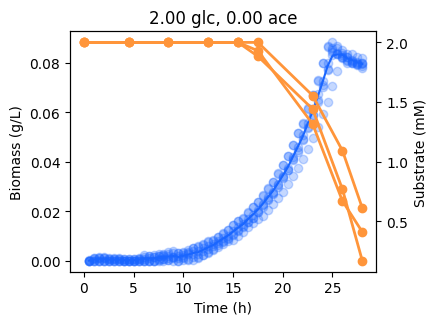

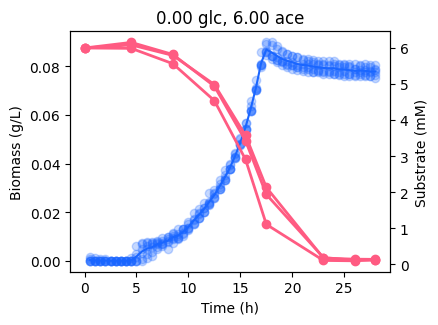

In [7]:
# To fit the uptake parameters, the plan is to:
# 1. Extract the region of data where the uptake rate is likely saturated (i.e. dN/dt ~= constant * X).
#    I assume this is true for the exponential phase of growth, so I extract that portion of the growth curve below.
# 2. Next, I fit the V_maxes by fitting the nutrient data over the exponential period. To do so, I used WolframAlpha to
#    solve dN/dt = -V_max * X(t), with X(t) = X_0 * exp(mu * t). The solution is listed below.
#    Note that using the closed-form solution does not take into account all the X(t) datapoints, so it may be slightly better
#    to use numerical integration to fit the V_maxes.
# 3. Finally, I fit the K_m's by fitting the nutrient data over the whole growth curve, fixing the V_maxes from above.

# Plot data function for use later
def plot_data(ax, t_X_obs, X_obs_replicates, t_N_obs, N_obs_replicates, lw=2, N_color = C_GLUCOSE):
    ax.plot(t_X_obs, X_obs_replicates.T, marker="o", lw=0, color=C_BIOMASS, alpha=0.25)
    ax.plot(t_X_obs, X_obs_replicates.mean(axis=0), color=C_BIOMASS)
    ax2 = ax.twinx()
    ax2.plot(t_N_obs, N_obs_replicates.T, marker="o", lw=lw, color=N_color)

    ax.set_xlabel("Time (h)")
    ax.set_ylabel("Biomass (g/L)")
    ax2.set_ylabel("Substrate (mM)")

    return ax, ax2

# Plot data
for (g, a), dat in data.items():
    if g > 0 and a > 0:
        continue
    
    # Get raw data
    t_X_obs = dat["raw"]["raw_b_t"]
    X_obs_replicates = dat["raw"]["raw_b"]
    t_N_obs = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_t"]
    N_obs_replicates = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_s"] 

    # Plot raw data
    fig, ax = plt.subplots()
    plot_data(ax, t_X_obs, X_obs_replicates, t_N_obs, N_obs_replicates, N_color = C_GLUCOSE if g > 0 else C_ACETATE)
    ax.set_title(f"{g.magnitude:.2f} glc, {a.magnitude:.2f} ace")
    fig.tight_layout()
    fig.set_size_inches(4, 3)


Growth terminates before substrates are exhausted - need to implement a time shift correction.

In [8]:
data

{(<Quantity(2.0, 'millimolar')>,
  <Quantity(0.0, 'millimolar')>): {'raw': {'raw_b_t': array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
           6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
          11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5,
          17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. ,
          22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5,
          28. ]),
   'raw_b': array([[4.51500e-04, 6.45000e-05, 0.00000e+00, 0.00000e+00, 0.00000e+00,
           0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
           1.22550e-03, 8.38500e-04, 1.22550e-03, 1.61250e-03, 1.99950e-03,
           1.99950e-03, 1.99950e-03, 1.61250e-03, 1.99950e-03, 2.38650e-03,
           2.77350e-03, 2.77350e-03, 2.77350e-03, 3.93450e-03, 4.70850e-03,
           5.86950e-03, 7.03050e-03, 8.19150e-03, 9.35250e-03, 1.09005e-02,
           1.24485e-02, 1.39965e-02, 1.55445e-02, 1.7